In [1]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import tqdm
from time import sleep
import time
from PIL import Image
from io import BytesIO
from adjustText import adjust_text
from scipy.interpolate import interp1d
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name, get_teams, find_team_name_by_id
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail


In [2]:
from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats


In [3]:
from nba_api.stats.endpoints.commonteamroster import CommonTeamRoster

In [4]:
atlanta_id = "1610612737"

In [5]:
cur_season = CommonTeamRoster(team_id=atlanta_id, season='2020-21').get_data_frames()[0]

In [6]:
past_season = CommonTeamRoster(team_id=atlanta_id, season='2019-20').get_data_frames()[0]

In [7]:
remaining_players = cur_season.loc[cur_season.PLAYER.isin(past_season.PLAYER)]

In [8]:
new_players = cur_season.loc[~cur_season.PLAYER.isin(past_season.PLAYER)]

In [9]:
remaining_players

,TeamID,SEASON,LeagueID,PLAYER,PLAYER_SLUG,NUM,POSITION,HEIGHT,WEIGHT,BIRTH_DATE,AGE,EXP,SCHOOL,PLAYER_ID
0,1610612737,2020,00,Brandon Goodwin,brandon-goodwin,0,G,6-0,180,"OCT 02, 1995",25.0,2,Florida Gulf Coast,1629164
2,1610612737,2020,00,Kevin Huerter,kevin-huerter,3,G-F,6-7,190,"AUG 27, 1998",22.0,2,Maryland,1628989
6,1610612737,2020,00,Trae Young,trae-young,11,G,6-1,180,"SEP 19, 1998",22.0,2,Oklahoma,1629027
7,1610612737,2020,00,De'Andre Hunter,deandre-hunter,12,F-G,6-7,225,"DEC 02, 1997",23.0,1,Virginia,1629631
9,1610612737,2020,00,Clint Capela,clint-capela,15,C,6-10,240,"MAY 18, 1994",26.0,6,Elan Chalon,203991
13,1610612737,2020,00,John Collins,john-collins,20,F-C,6-9,235,"SEP 23, 1997",23.0,3,Wake Forest,1628381
14,1610612737,2020,00,Cam Reddish,cam-reddish,22,F-G,6-8,218,"SEP 01, 1999",21.0,1,Duke,1629629
15,1610612737,2020,00,Bruno Fernando,bruno-fernando,24,F-C,6-9,240,"AUG 15, 1998",22.0,1,Maryland,1628981


In [10]:
new_players

,TeamID,SEASON,LeagueID,PLAYER,PLAYER_SLUG,NUM,POSITION,HEIGHT,WEIGHT,BIRTH_DATE,AGE,EXP,SCHOOL,PLAYER_ID
1,1610612737,2020,00,Nathan Knight,nathan-knight,1,F-C,6-10,253,"SEP 20, 1997",23.0,R,William & Mary,1630233
3,1610612737,2020,00,Skylar Mays,skylar-mays,4,G,6-4,205,"SEP 05, 1997",23.0,R,Louisiana State,1630219
4,1610612737,2020,00,Rajon Rondo,rajon-rondo,7,G,6-1,180,"FEB 22, 1986",34.0,14,Kentucky,200765
5,1610612737,2020,00,Danilo Gallinari,danilo-gallinari,8,F,6-10,233,"AUG 08, 1988",32.0,11,Olimpia Milano,201568
8,1610612737,2020,00,Bogdan Bogdanovic,bogdan-bogdanovic,13,G,6-6,220,"AUG 18, 1992",28.0,3,Fenerbahce,203992
10,1610612737,2020,00,Onyeka Okongwu,onyeka-okongwu,17,F-C,6-9,235,"DEC 11, 2000",19.0,R,Southern California,1630168
11,1610612737,2020,00,Solomon Hill,solomon-hill,18,F,6-6,226,"MAR 18, 1991",29.0,7,Arizona,203524
12,1610612737,2020,00,Tony Snell,tony-snell,19,G,6-6,213,"NOV 10, 1991",29.0,7,New Mexico,203503
16,1610612737,2020,00,Kris Dunn,kris-dunn,32,G,6-3,205,"MAR 18, 1994",26.0,4,Providence,1627739


## Scoring overview

In [10]:
play_types = [
    "PRBallHandler",
    "Isolation",
    "Transition",
    "Spotup",
    "Handoff",
    "OffScreen",
    "Cut",
    "OffRebound",
    "Postup",
    "PRRollman",
]

play_types_seasons = {}


    
def get_playtype_regular_data(target_id, season='2019-20'):
    
    play_type_dict = {}
    if season not in play_types_seasons:
        print("Retrieving play types...")
        for play in play_types:
            synergy = SynergyPlayTypes(player_or_team_abbreviation='P', play_type_nullable=play, type_grouping_nullable="offensive", per_mode_simple="PerGame", season=season)
            synergy_df = synergy.get_data_frames()[0]
            play_type_dict[play] = synergy_df
            time.sleep(1)
        play_types_seasons[season] = play_type_dict
    else:
        play_type_dict = play_types_seasons[season]

    
    team_play_type_regular = []

    cur_player_data = {}
    for play in play_types:
        cur_df = play_type_dict[play]
        key = 'PLAYER_ID'
        subset = cur_df.loc[cur_df[key] == target_id]
        subset = cur_df.loc[cur_df[key] == target_id]
        if len(subset) == 0:
            cur_player_data[play] = 0.05
        else:
            cur_player_data[play] = subset.iloc[0].PTS
        
        
    #teams_pt_df = pd.concat(team_play_type_regular).loc[:, ['PLAY_TYPE', 'PTS']].pivot_table(index='PLAY_TYPE', values='PTS').transpose().iloc[0]
    return pd.Series(cur_player_data)




In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

def plot_radar(
    title,
    data,
    labels,
    colors,
    alphas):
    # number of variable
    categories=list(data[0].tolist())
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    fig = plt.figure(figsize=(12, 12))
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], [item.replace("_", " ") for item in data[0].index.tolist()])
    for label,i in zip(ax.get_xticklabels(),range(0,len(angles))):

        angle_rad=angles[i]
        if angle_rad <= pi/2:
            ha= 'left'
            va= "bottom"
            angle_text=angle_rad*(-180/pi)+90
        elif pi/2 < angle_rad <= pi:
            ha= 'left'
            va= "top"
            angle_text=angle_rad*(-180/pi)+90
        elif pi < angle_rad <= (3*pi/2):
            ha= 'right'
            va= "top"  
            angle_text=angle_rad*(-180/pi)-90
        else:
            ha= 'right'
            va= "bottom"
            angle_text=angle_rad*(-180/pi)-90
        label.set_rotation(angle_text)
        label.set_verticalalignment(va)
        label.set_horizontalalignment(ha)


    # Draw ylabels
    ax.set_rlabel_position(0)
    #items = [item / 10 for item in range(0, 55, 10)]
    #plt.yticks(items, map(str, items), size=12)
    #ax.spines['polar'].set_color('#cbcbcb')
    #ax.spines['polar'].set_linewidth('1')
    
    max_val = max([item.max() for item in data])
    plt.ylim(0, max_val + 0.05 * max_val)
    ax.spines['polar'].set_visible(False)

    plt.title(title, color='black', size=20)
    
    for i in range(len(data)):
    
        cur_data = data[i]
        values=cur_data.tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=labels[i], color=colors[i])
        ax.fill(angles, values, colors[i], alpha=alphas[i])
    
    legend = plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=14)
    
    #ax.set_yticklabels(f"{item}%" for item in range(5, 35, 5))


    ax.set_frame_on(False)
    ax.set_axisbelow(True)
    #ax.set_facecolor(bball_gray)
    #fig.set_facecolor(bball_gray)

In [12]:
from nba_api.stats.endpoints.teamplayerdashboard import TeamPlayerDashboard

league_stats = TeamPlayerDashboard(team_id=atlanta_id, season='2019-20', per_mode_detailed='PerGame')
stats_df = league_stats.get_data_frames()[1]



In [13]:
relevant_players = stats_df.loc[stats_df.GP > 30]

In [14]:
new_players = [
    'Rajon Rondo',
    'Danilo Gallinari',
    'Bogdan Bogdanovic',
    'Solomon Hill',
    'Tony Snell',
    'Kris Dunn'
]

new_player_ids = {}
for player in new_players:
    new_player_ids[player] = find_players_by_full_name(player)[0]['id']

In [15]:
new_player_ids

{'Rajon Rondo': 200765,
 'Danilo Gallinari': 201568,
 'Bogdan Bogdanovic': 203992,
 'Solomon Hill': 203524,
 'Tony Snell': 203503,
 'Kris Dunn': 1627739}

In [16]:
old_players = []
for index in range(len(relevant_players)):
    item = relevant_players.iloc[index]
    if item.PLAYER_NAME == 'Trae Young':
        continue
    data = get_playtype_regular_data(target_id=item.PLAYER_ID, season='2019-20')
    old_players.append(data)
    
new_players = []
for player_name in new_player_ids:
    new_players.append(get_playtype_regular_data(target_id=new_player_ids[player_name], season='2019-20'))

Retrieving play types...


In [17]:
plt.style.use('fivethirtyeight')

In [18]:
colors = ['#008fd5', '#fc4f30', '#e5ae38', '#810f7c', '#113537', '#6d904f', '#3E2A35']

Text(9.4, 4.5, 'Na grafu nema Traea Younga\nkoji gotovo sve postiže iz\nPick and Rolla')

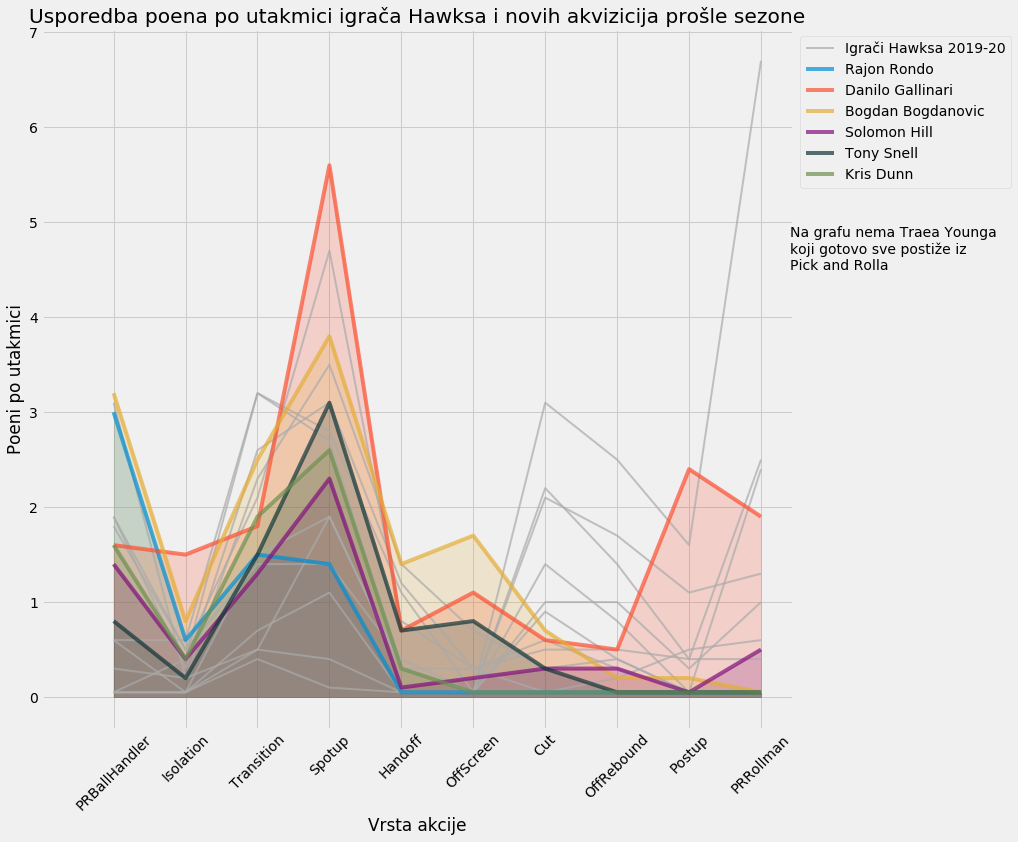

In [20]:
fig, ax = plt.subplots(figsize=(12, 12))

for index, item in enumerate(old_players):
    print()
    ax.plot([
        item[play] for play in play_types
    ], color='#AAAAAA', alpha=0.7, lw=2, label='Igrači Hawksa 2019-20' if index == 0 else None)
    
    
for index, item in enumerate(new_players):
    player_name = list(new_player_ids.keys())[index]
    #item = pd.Series(item)
    ax.plot([
        item[play] for play in play_types
    ], alpha=0.7, lw=4, label=player_name, color=colors[index])
    x = np.arange(len(play_types))
    y = np.array([item[play] for play in play_types])
    ax.fill_between(x, y, alpha=0.2, color=colors[index])
    
ax.set_xticklabels([''] + play_types, rotation=45)
ax.set_xticks(range(-1, len(play_types)))
ax.legend(loc='upper left', bbox_to_anchor=(1., 1))
ax.set_xlabel("Vrsta akcije")
ax.set_ylabel("Poeni po utakmici")

ax.set_title("Usporedba poena po utakmici igrača Hawksa i novih akvizicija prošle sezone")
ax.text(x=9.4, y=4.5, s='Na grafu nema Traea Younga\nkoji gotovo sve postiže iz\nPick and Rolla')

Dvije glavne akvizicije su svakako Gallinari i Bogdanović, dva krilna igrača koja će osnažiti ovu sjajnu ekipu. Napad Hawksa teče kroz Pick and Roll, drugi su u ligi po broju napada preko Ball Handlera u pick and rollu, ali su drugi i u napadima preko "Roll Mana" u pick and rollu (ball handler je Trae, a Roll man je npr. Collins). 

Collins je jedan vrlo svestrani ofenzivni igrač, sposoban je napadati preko rolla, ali i preko "Pick and Popa", prošle sezone je šutirao preko 40% na trici. A kao što možete vidjeti iz spotup dijela, Trae je dobio još nekoliko vrlo dobrih šutera. Gallinari i Bogdan su definitivno "elitni" šuteri, dok je Snell respektabilan role player koji će uskakati prilikom odmora prve dvojice. 

Uz to, Trae je konačno dobio i respektabilne zamjene. Rondo će uživati u pick and rollu s Collinsom ili centrima Capelom (ukoliko bude uopće igrao) te rookijem Okongwuom koji je vrlo dobar pick and roll igrač sudeći po scouting reportovima i siguran sam da će se savršeno uklopiti u napad Hawksa uz Younga. E da, tu je i Kris Dunn, koji je po meni jedan od najboljih obrambenih bekova u cijeloj ligi, usudio bih se smjestiti ga u top 5 bekova. Nažalost, to je jedina stavka u kojoj pridonosi, ali svakako postoji opcija da igra uz Younga protiv problematičnih bekova. 



### Todo

* Možda graf gdje idu Traeove asistencije u prosjeku na ostale top 10 asistente (ovo na terenu neka bude)

* Breakdown Traeovih asistencija vs Ostali igrači (Tablica)

* Wide Open šutovi Hawksovih igrača (scatter plot)

* Neki obrambeni outlook, iako nisam ni ja prepametan za tako neš što i kako (Dunn vs Young?)

### Analyzing Trae's assists

In [19]:
pbp_df = pd.read_csv('../../2019_20_season/play_by_plays/full_pbp_2019_20_dropped.csv')

In [20]:
shot_df_atl = ShotChartDetail(team_id=atlanta_id, player_id=0, season_nullable='2019-20')

In [21]:
shot_df_atl = shot_df_atl.get_data_frames()[0]

In [22]:
pbp_df.loc[:, "GAME_ID_STR"] = ["00" + str(item) for item in pbp_df.GAME_ID.tolist()]

In [23]:
atlanta_merged = pd.merge(left=pbp_df, right=shot_df_atl, left_on=('GAME_ID_STR', 'EVENTNUM'), right_on=('GAME_ID', 'GAME_EVENT_ID'))

In [24]:
trae_id = find_players_by_full_name("Trae Young")[0]['id']

In [25]:
trae_assists = atlanta_merged.loc[atlanta_merged.PLAYER2_ID == trae_id]

In [26]:
import random
from matplotlib.patches import Circle, Rectangle, Arc

# Amazing function by Bradley Fay for plotting the nba court
# source: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
def draw_court(ax=None, color='black', lw=2, background_color="#EBEBE8", outer_lines=False, zorder=None):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False, zorder=zorder)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color, zorder=zorder)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False, zorder=zorder)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False, zorder=zorder)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False, zorder=zorder)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed', zorder=zorder)
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color, zorder=zorder)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 138, linewidth=lw,
                               color=color, zorder=zorder)
    corner_three_b = Rectangle((220, -47.5), 0, 138, linewidth=lw, color=color, zorder=zorder)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22.13, theta2=157.87, linewidth=lw,
                    color=color, zorder=7)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=zorder)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=zorder)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]
    
    # Draw the half court line, baseline and side out bound lines
    outer_lines = Rectangle((-249, -48), 498, 470, linewidth=lw,
                            color=color, fill=None, zorder=7)
    court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [27]:
def plot_raw_shotchart(data_frame, title, ax=None, mode="dark", plot_fg_made = False):
    plt.style.use('fivethirtyeight')
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 14))
    
    #made_shots = data_frame.loc[data_frame.SHOT_MADE_FLAG == 1]
    #created_shots = data_frame.loc[data_frame.ACTION_TYPE.isin(created)]
    #catch_and_shoot = data_frame.loc[data_frame.ACTION_TYPE.isin(non_created)]
    yellow = '#FFCD00'
    
    paths = ax.scatter(
        x=data_frame.LOC_X,
        y=data_frame.LOC_Y,
        marker='o',
        c="#E03A3E",
        edgecolors='black',
        s=180,
        alpha=0.95,
        label='Asistiran šut'
    )
    
    """paths = ax.scatter(
        x=created_shots.LOC_X,
        y=created_shots.LOC_Y,
        marker='o',
        c=yellow,
        edgecolors='black',
        s=180,
        alpha=0.95,
        label='"Created" shots'
    )
    """
    
    if mode == 'dark':
        background_color="#232323"
        font_color="#E8E8FF"
    else:
        background_color="#EBEBE8"
        font_color = "#454545"
        
    if plot_fg_made:
        original_df = data_frame
        df_by_zone_sum = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA']).sum()
        df_by_zone_sum.loc[:, 'ZONE_PCT'] = (df_by_zone_sum.SHOT_MADE_FLAG / df_by_zone_sum.SHOT_ATTEMPTED_FLAG) * 100
        df_by_zone_median = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA']).median()
        for index in range(len(df_by_zone_median)):
            loc_x = df_by_zone_median.iloc[index].LOC_X
            loc_y = df_by_zone_median.iloc[index].LOC_Y
            zone_percentage = df_by_zone_sum.iloc[index].ZONE_PCT
            zone_shots_made = df_by_zone_sum.iloc[index].SHOT_MADE_FLAG
            zone_shots_attempted = df_by_zone_sum.iloc[index].SHOT_ATTEMPTED_FLAG
            if zone_shots_attempted < 5:
                continue
            ax.text(x=loc_x, y=loc_y+10, s=f"{float(zone_shots_made) / len(data_frame) * 100:.2f}%", ha='center', c='black',
                   bbox={'facecolor': '#F3F3A9', 'alpha': 0.75, 'edgecolor': 'black'})
    
    
    ax.text(x=245, y=360, s=f"Broj u kvadratićima predstavlja\npostotak ukupnih asistencija", c='black',
                   bbox={'facecolor': '#f0f0f0', 'alpha': 0.75, 'edgecolor': '#e0e0e0'}, ha='right')
    # Changing court color
    #ax.set_facecolor('#FFFAFA')
    team_id = data_frame.iloc[0].TEAM_ID
    player_id = data_frame.iloc[0].PLAYER2_ID
    url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/{team_id}/2019/260x190/{player_id}.png"
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # 140, 102
    ax.imshow(img, extent=(112, 252, -47, 55), zorder=7)
    # Legend

    # Removing ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.grid(False)

    # Title
    ax.set_title(title, size=20)
    
    # Drawing court
    draw_court(ax=ax,outer_lines=True, lw=3, background_color=background_color)
    ax.set_xlim(-251,251)
    ax.set_ylim(-65,423)

    
    ax.legend(loc='upper right')
    

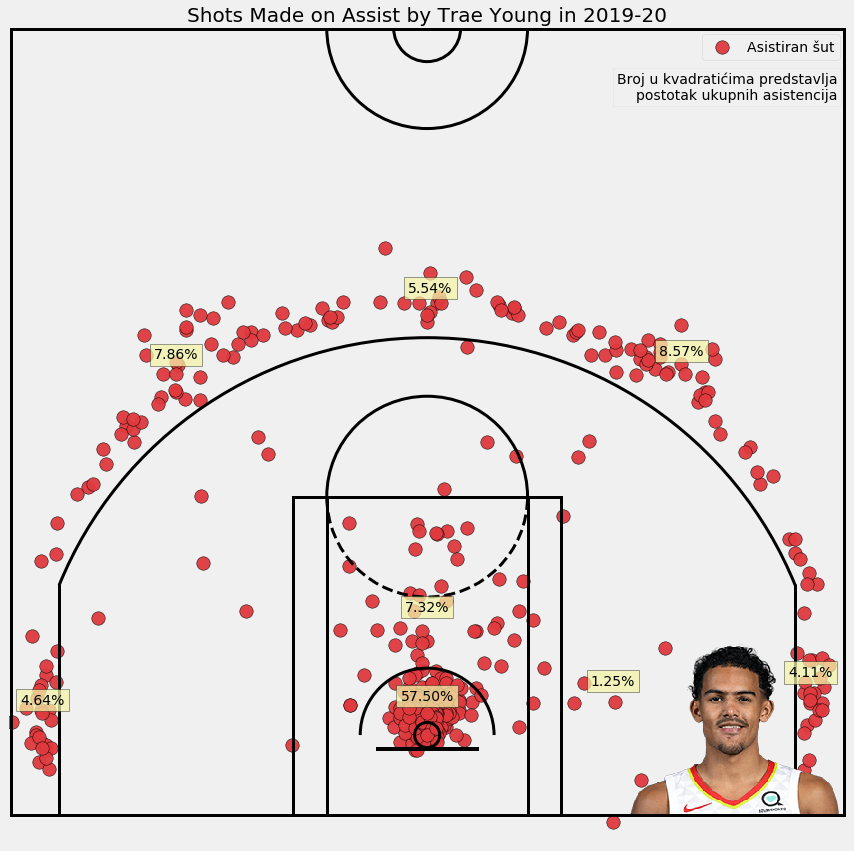

In [105]:
plot_raw_shotchart(data_frame=trae_assists, title='Shots Made on Assist by Trae Young in 2019-20', mode='light', plot_fg_made=True)

In [34]:
shot_df_lal = ShotChartDetail(team_id=find_teams_by_full_name("Los Angeles Lakers")[0]['id'], player_id=0, season_nullable='2019-20')

shot_df_lal = shot_df_lal.get_data_frames()[0]
lal_merged = pd.merge(left=pbp_df, right=shot_df_lal, left_on=('GAME_ID_STR', 'EVENTNUM'), right_on=('GAME_ID', 'GAME_EVENT_ID'))

In [37]:
lebron_assists = lal_merged.loc[lal_merged.PLAYER2_ID == find_players_by_full_name("LeBron James")[0]['id']]

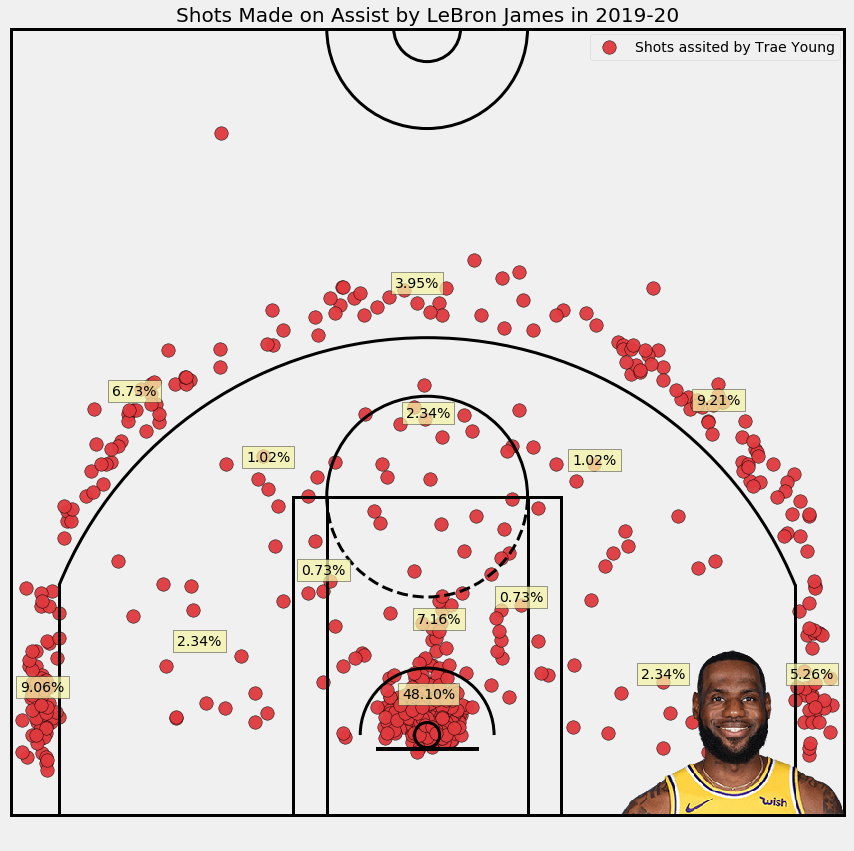

In [49]:
plot_raw_shotchart(data_frame=lebron_assists, title='Shots Made on Assist by LeBron James in 2019-20', mode='light', plot_fg_made=True)

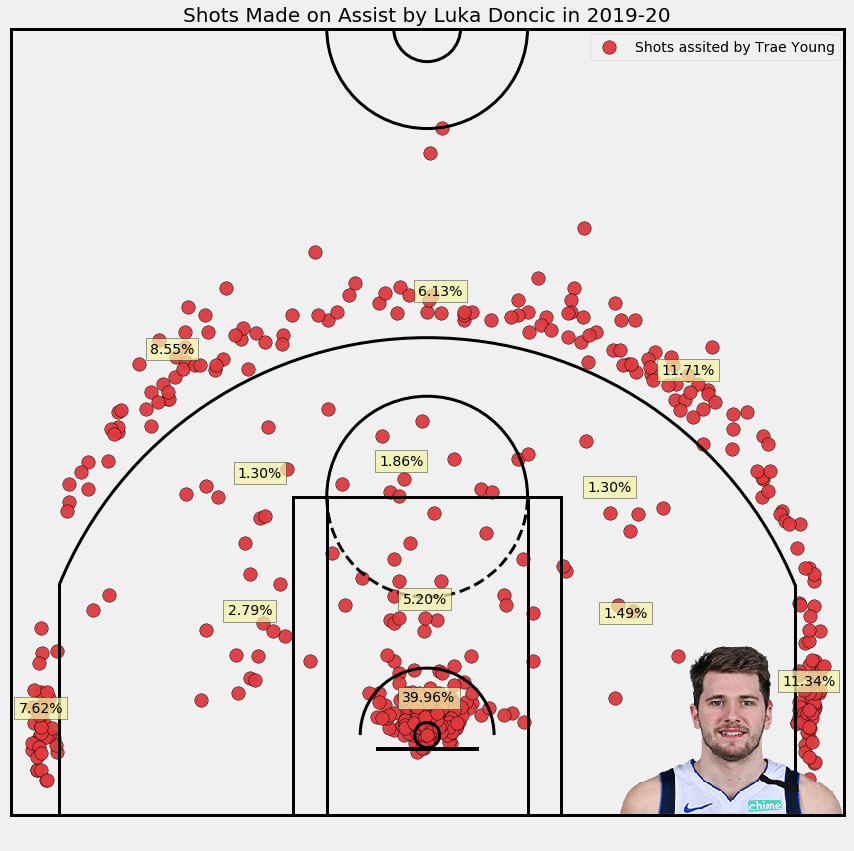

In [51]:
shot_df = ShotChartDetail(team_id=find_teams_by_full_name("Dallas Mavericks")[0]['id'], player_id=0, season_nullable='2019-20')

shot_df = shot_df.get_data_frames()[0]
df_merged = pd.merge(left=pbp_df, right=shot_df, left_on=('GAME_ID_STR', 'EVENTNUM'), right_on=('GAME_ID', 'GAME_EVENT_ID'))

player_assists = df_merged.loc[df_merged.PLAYER2_ID == find_players_by_full_name("Luka Doncic")[0]['id']]

plot_raw_shotchart(data_frame=player_assists, title='Shots Made on Assist by Luka Doncic in 2019-20', mode='light', plot_fg_made=True)

In [64]:
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

In [65]:
player_stats = LeagueDashPlayerStats(per_mode_detailed='PerGame', season='2019-20').get_data_frames()[0]

In [72]:
top_assists = player_stats.sort_values(by='AST', ascending=False).iloc[:9]

In [74]:
all_shots = ShotChartDetail(team_id=0, player_id=0, season_nullable='2019-20')

In [75]:
all_df = all_shots.get_data_frames()[0]

In [ ]:
all_df.loc[all_df.TEAM_ID]

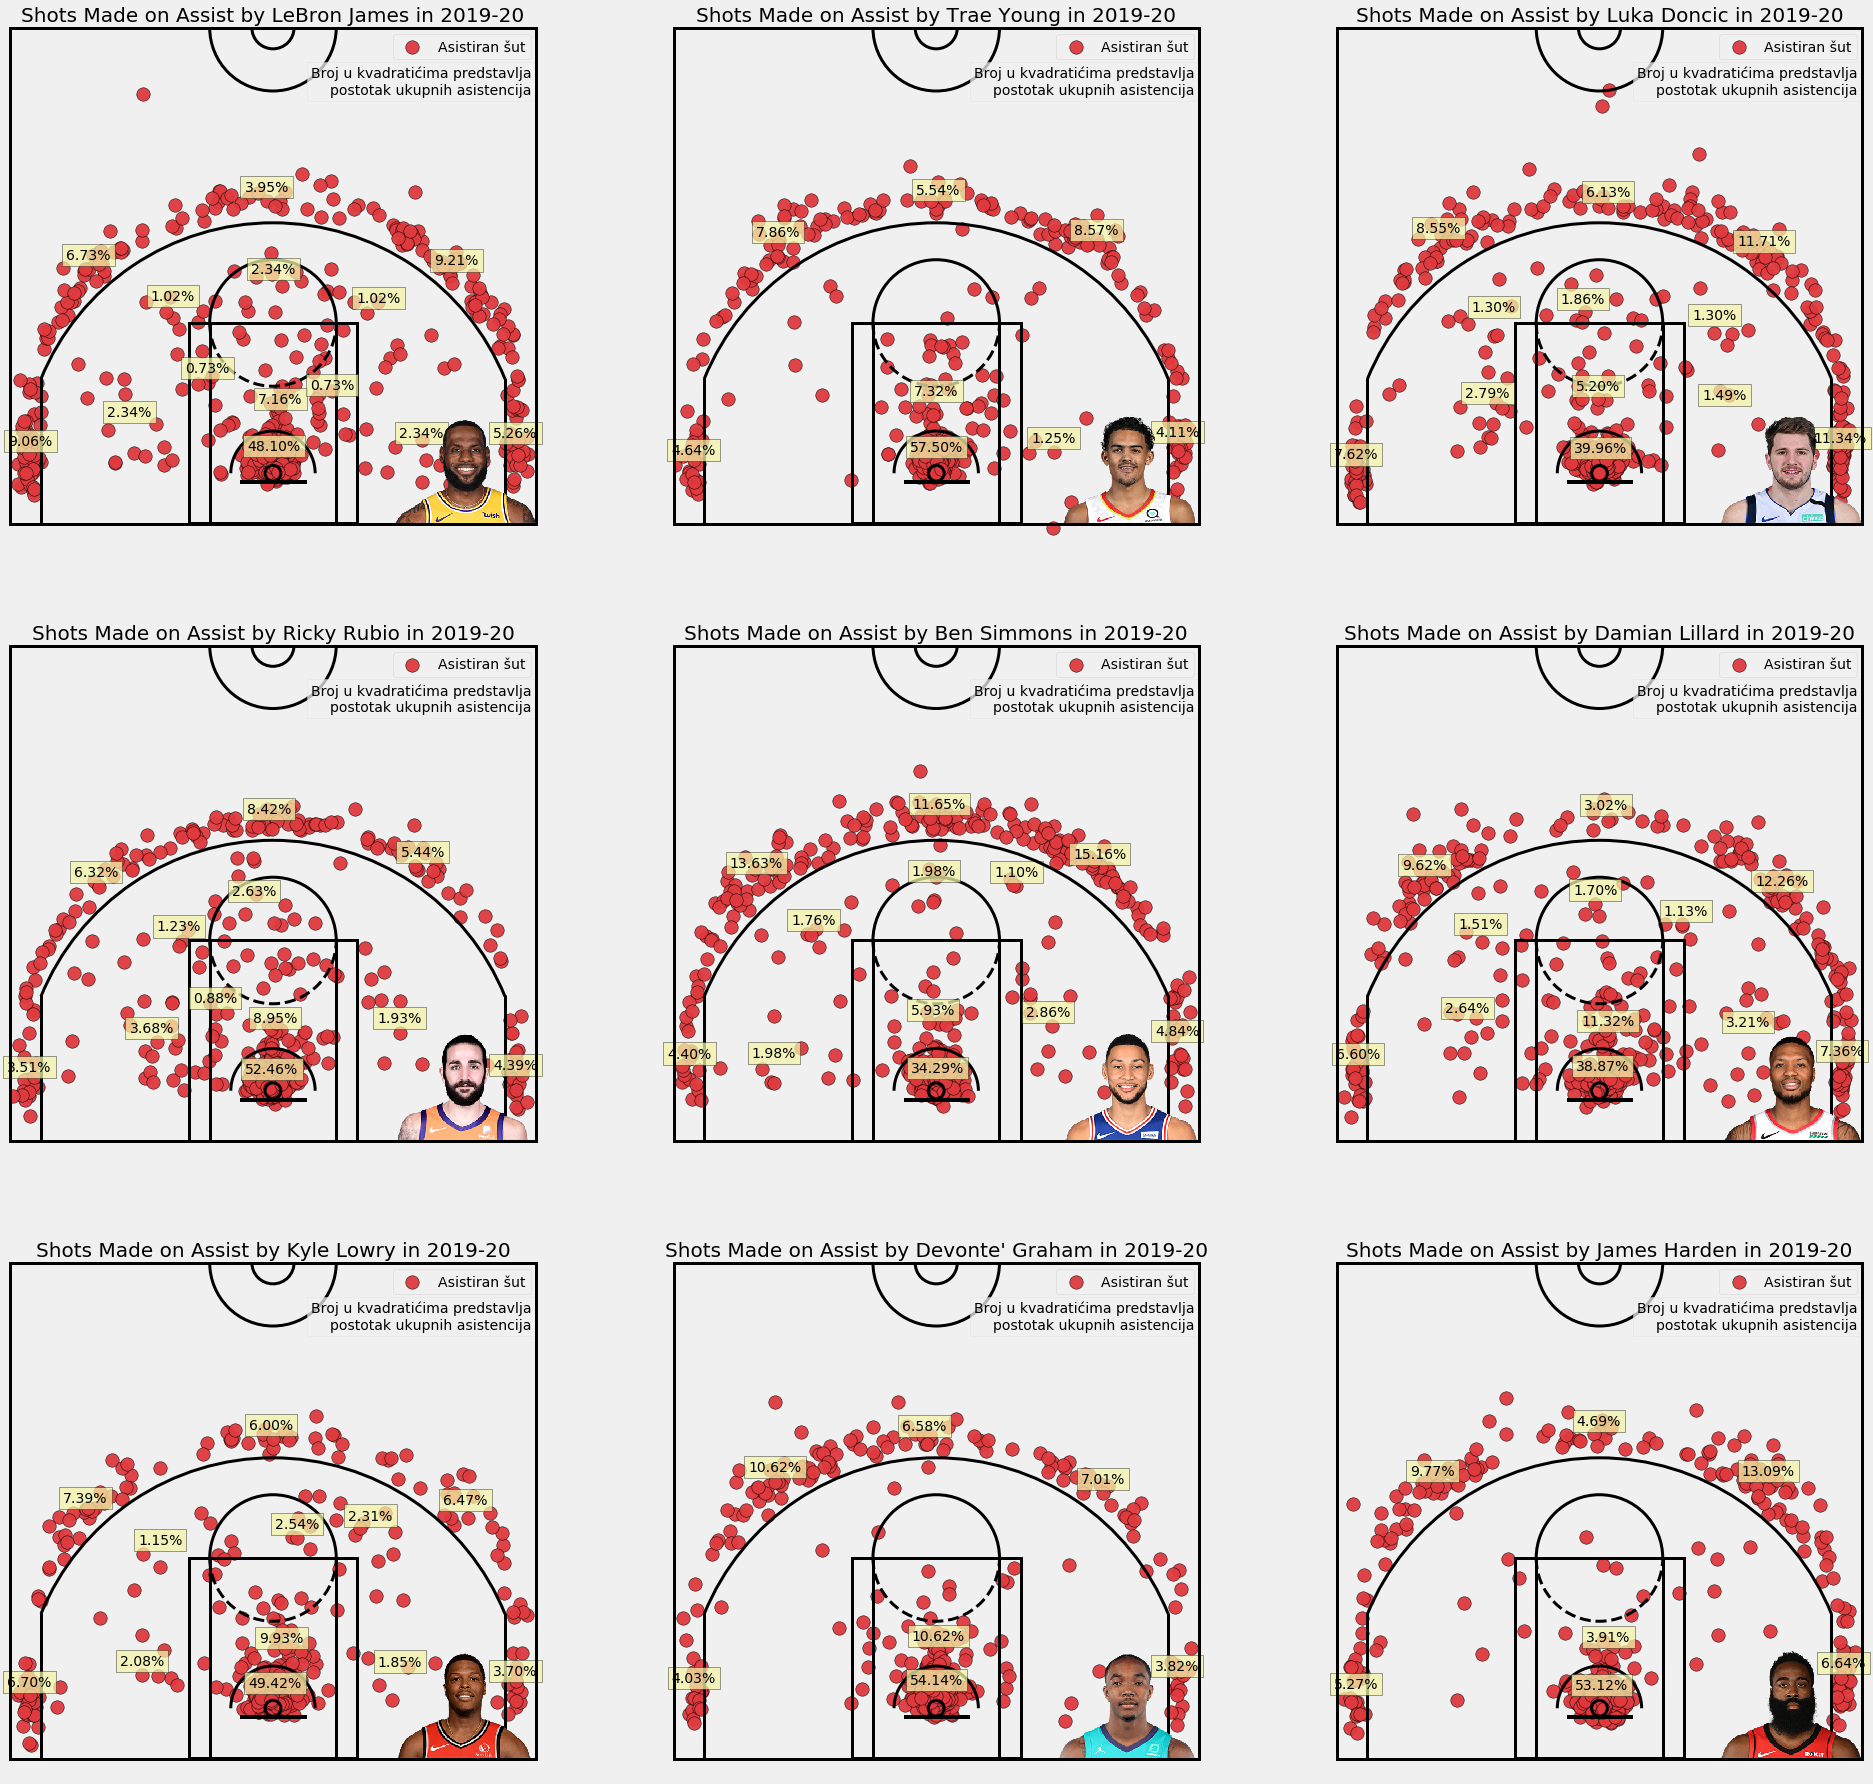

In [110]:
fig, ax = plt.subplots(3, 3, figsize=(30, 30))

axes = ax.flatten()

for index in range(len(top_assists)):
    item = top_assists.iloc[index]
    cur_ax = axes[index]
    shot_df = all_df.loc[all_df.TEAM_ID == item.TEAM_ID]

    #shot_df = shot_df.get_data_frames()[0]
    df_merged = pd.merge(left=pbp_df, right=shot_df, left_on=('GAME_ID_STR', 'EVENTNUM'), right_on=('GAME_ID', 'GAME_EVENT_ID'))

    player_assists = df_merged.loc[df_merged.PLAYER2_ID == item.PLAYER_ID]
    plot_raw_shotchart(data_frame=player_assists, title=f'Shots Made on Assist by {item.PLAYER_NAME} in 2019-20', mode='light', plot_fg_made=True, ax=cur_ax)

### Wide open šutevi

In [111]:
open_shot = "6+ Feet - Wide Open"

In [112]:
from nba_api.stats.endpoints.leaguedashteamptshot import LeagueDashTeamPtShot

In [113]:
wide_open_shots = LeagueDashTeamPtShot(per_mode_simple="PerGame", season='2019-20', close_def_dist_range_nullable=open_shot)
open_shots = LeagueDashTeamPtShot(per_mode_simple="PerGame", season='2019-20', close_def_dist_range_nullable="4-6 Feet - Open")

In [114]:
wide_open_df = wide_open_shots.get_data_frames()[0]
open_df = open_shots.get_data_frames()[0]

In [116]:
merged_df = pd.merge(left=open_df, right=wide_open_df, on='TEAM_ID', suffixes=('_OPEN', '_WIDE_OPEN'))

In [120]:
merged_df.loc[:, 'FG3M_TOTAL'] = merged_df.FG3M_OPEN + merged_df.FG3M_WIDE_OPEN
merged_df.loc[:, 'FG3A_TOTAL'] = merged_df.FG3A_OPEN + merged_df.FG3A_WIDE_OPEN
merged_df.loc[:, 'FG3_PCT_TOTAL'] = round((merged_df.FG3M_TOTAL / merged_df.FG3A_TOTAL) * 100, 2)

In [123]:
merged_df.loc[merged_df.TEAM_ID == int(atlanta_id)]

,TEAM_ID,TEAM_NAME_OPEN,TEAM_ABBREVIATION_OPEN,GP_OPEN,G_OPEN,FGA_FREQUENCY_OPEN,FGM_OPEN,FGA_OPEN,FG_PCT_OPEN,EFG_PCT_OPEN,...,FG2M_WIDE_OPEN,FG2A_WIDE_OPEN,FG2_PCT_WIDE_OPEN,FG3A_FREQUENCY_WIDE_OPEN,FG3M_WIDE_OPEN,FG3A_WIDE_OPEN,FG3_PCT_WIDE_OPEN,FG3M_TOTAL,FG3A_TOTAL,FG3_PCT_TOTAL
18,1610612737,Atlanta Hawks,ATL,67,67,0.275,10.3,24.84,0.415,0.503,...,1.79,3.0,0.597,0.2,6.69,18.1,0.369,11.09,32.25,34.39


Text(0.5, 38.97999999999996, 'Broj šuteva po utakmici')

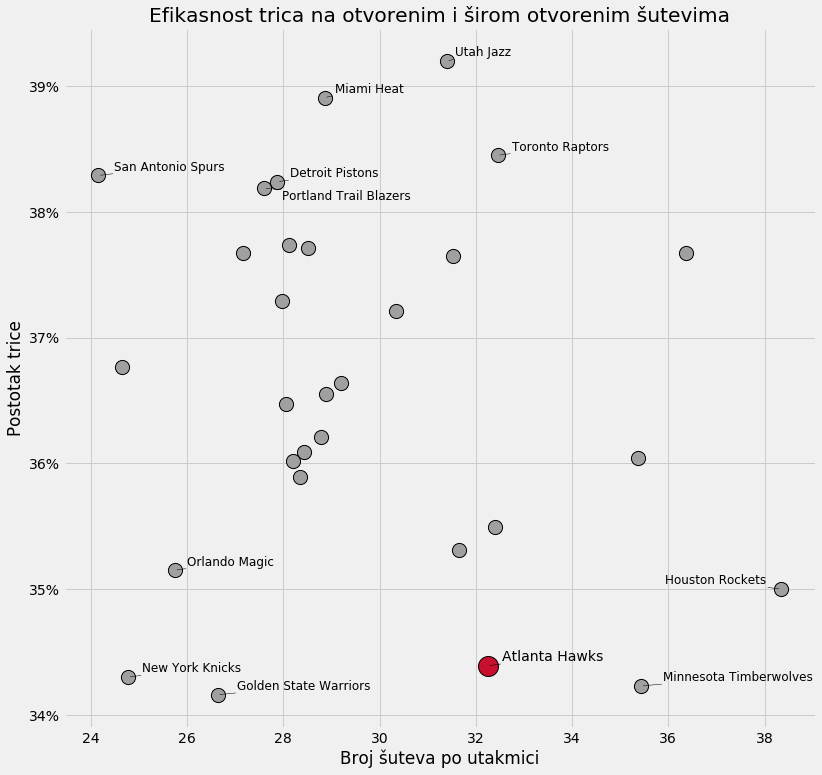

In [139]:
fig, ax = plt.subplots(figsize=(12, 12))

hawks_only = merged_df.loc[merged_df.TEAM_ID == int(atlanta_id)]
other = merged_df.loc[merged_df.TEAM_ID != int(atlanta_id)]
top_5 = other.sort_values(by='FG3_PCT_TOTAL', ascending=False).iloc[:6]
bottom_5 = other.sort_values(by='FG3_PCT_TOTAL', ascending=True).iloc[:6]
ax.scatter(x=other.FG3A_TOTAL, y=other.FG3_PCT_TOTAL, s=200, color='#A0A0A0', edgecolors='black', lw=1)
ax.scatter(x=hawks_only.FG3A_TOTAL, y=hawks_only.FG3_PCT_TOTAL, s=400, color='#C8102E', edgecolors='black', lw=1)

texts = [ax.text(x=hawks_only.iloc[0].FG3A_TOTAL, y=hawks_only.iloc[0].FG3_PCT_TOTAL, s='Atlanta Hawks')]
for index in range(len(top_5)):
    item = top_5.iloc[index]
    texts.append(ax.text(x=item.FG3A_TOTAL, y=item.FG3_PCT_TOTAL, s=item.TEAM_NAME_OPEN, size=12))
    if index > 4:
        continue
    item = bottom_5.iloc[index]
    texts.append(ax.text(x=item.FG3A_TOTAL, y=item.FG3_PCT_TOTAL, s=item.TEAM_NAME_OPEN, size=12))
adjust_text(texts, arrowprops={'arrowstyle': '-', 'color': 'black'}, expand_points=(1.3, 1.3))
ax.set_title("Efikasnost trica na otvorenim i širom otvorenim šutevima")
ax.set_ylabel("Postotak trice")
ax.set_yticklabels([f"{item}%" for item in range(33, 40)])
ax.set_xlabel("Broj šuteva po utakmici")

### Players wide open

In [140]:
from nba_api.stats.endpoints.leaguedashplayerptshot import LeagueDashPlayerPtShot

In [141]:
wide_open_shots = LeagueDashPlayerPtShot(per_mode_simple="PerGame", season='2019-20', close_def_dist_range_nullable=open_shot)
open_shots = LeagueDashPlayerPtShot(per_mode_simple="PerGame", season='2019-20', close_def_dist_range_nullable="4-6 Feet - Open")

In [142]:
wide_open_df = wide_open_shots.get_data_frames()[0]
open_df = open_shots.get_data_frames()[0]

In [144]:
merged_df = pd.merge(left=open_df, right=wide_open_df, on='PLAYER_ID', suffixes=('_OPEN', '_WIDE_OPEN'))

In [146]:
merged_df = merged_df.fillna(0.0)

In [151]:
merged_df = merged_df.loc[(merged_df.FG3A_OPEN > 0.4) & (merged_df.GP_OPEN > 20)]

In [152]:
merged_df.loc[:, 'FG3M_TOTAL'] = merged_df.FG3M_OPEN + merged_df.FG3M_WIDE_OPEN
merged_df.loc[:, 'FG3A_TOTAL'] = merged_df.FG3A_OPEN + merged_df.FG3A_WIDE_OPEN
merged_df.loc[:, 'FG3_PCT_TOTAL'] = round((merged_df.FG3M_TOTAL / merged_df.FG3A_TOTAL) * 100, 2)

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [164]:
new_players = [
    'Rajon Rondo',
    'Danilo Gallinari',
    'Bogdan Bogdanovic',
    'Solomon Hill',
    'Tony Snell',
    'Kris Dunn'
]

new_player_ids = []
for player in new_players:
    new_player_ids.append(find_players_by_full_name(player)[0]['id'])

Text(0.5, 38.97999999999996, 'Broj šuteva po utakmici')

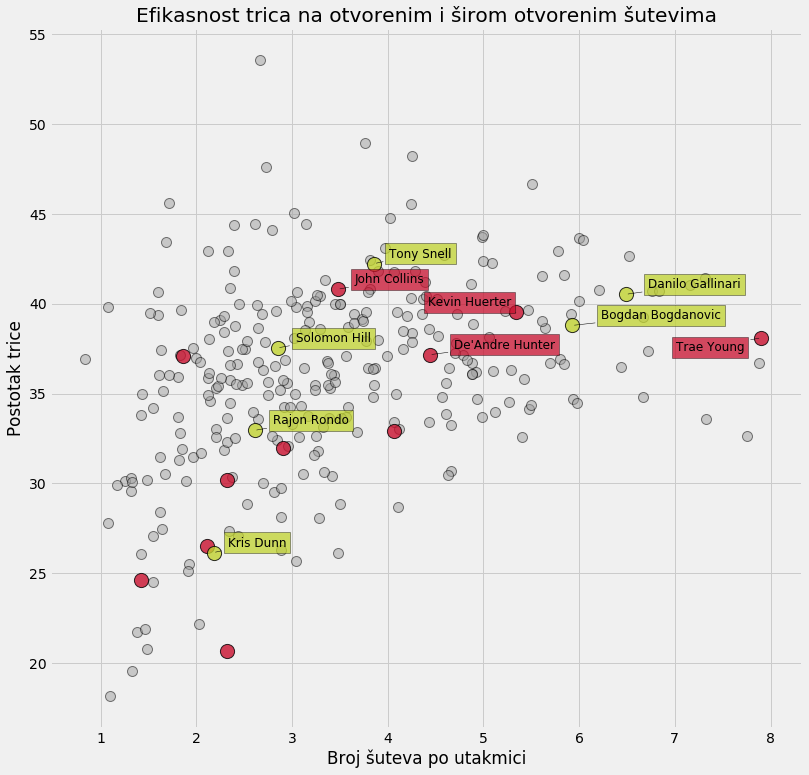

In [175]:
fig, ax = plt.subplots(figsize=(12, 12))

hawks_only = merged_df.loc[merged_df.PLAYER_LAST_TEAM_ABBREVIATION_OPEN == "ATL"]
top_hawks = hawks_only.sort_values(by='FG3_PCT_TOTAL', ascending=False).iloc[:4]
interesting_players = merged_df.loc[merged_df.PLAYER_ID.isin(new_player_ids)]
other = merged_df.loc[(merged_df.PLAYER_LAST_TEAM_ABBREVIATION_OPEN != "ATL") & (~merged_df.PLAYER_ID.isin(new_player_ids))]
#top_5 = other.sort_values(by='FG3_PCT_TOTAL', ascending=False).iloc[:6]
#bottom_5 = other.sort_values(by='FG3_PCT_TOTAL', ascending=True).iloc[:6]
ax.scatter(x=other.FG3A_TOTAL, y=other.FG3_PCT_TOTAL, s=100, color='#A0A0A0', edgecolors='black', alpha=0.5, lw=1)
ax.scatter(x=hawks_only.FG3A_TOTAL, y=hawks_only.FG3_PCT_TOTAL, s=200, color='#C8102E', edgecolors='black', alpha=0.8, lw=1)
ax.scatter(x=interesting_players.FG3A_TOTAL, y=interesting_players.FG3_PCT_TOTAL, s=200, color='#C1D32F', edgecolors='black', alpha=0.8, lw=1)


texts = []
for index in range(len(interesting_players)):
    item = interesting_players.iloc[index]
    texts.append(
        ax.text(x=item.FG3A_TOTAL, y=item.FG3_PCT_TOTAL, s=item.PLAYER_NAME_OPEN, size=12,
               bbox={'facecolor': '#C1D32F', 'alpha': 0.75, 'edgecolor': 'black'})
    )
    if index > 3:
        continue
    item = top_hawks.iloc[index]
    texts.append(
        ax.text(x=item.FG3A_TOTAL, y=item.FG3_PCT_TOTAL, s=item.PLAYER_NAME_OPEN, size=12,
               bbox={'facecolor': '#C8102E', 'alpha': 0.75, 'edgecolor': 'black'})
    )

adjust_text(texts, arrowprops={'arrowstyle': '-', 'color': 'black'}, expand_points=(1.5, 1.5), expand_text=(1.6, 1.6))
ax.set_title("Efikasnost trica na otvorenim i širom otvorenim šutevima")
ax.set_ylabel("Postotak trice")
#ax.set_yticklabels([f"{item}%" for item in range(33, 40)])
ax.set_xlabel("Broj šuteva po utakmici")

In [158]:
hawks_only

,PLAYER_ID,PLAYER_NAME_OPEN,PLAYER_LAST_TEAM_ID_OPEN,PLAYER_LAST_TEAM_ABBREVIATION_OPEN,AGE_OPEN,GP_OPEN,G_OPEN,FGA_FREQUENCY_OPEN,FGM_OPEN,FGA_OPEN,...,FG2M_WIDE_OPEN,FG2A_WIDE_OPEN,FG2_PCT_WIDE_OPEN,FG3A_FREQUENCY_WIDE_OPEN,FG3M_WIDE_OPEN,FG3A_WIDE_OPEN,FG3_PCT_WIDE_OPEN,FG3M_TOTAL,FG3A_TOTAL,FG3_PCT_TOTAL
16,1629027,Trae Young,1610612737,ATL,21.0,60,60,0.310,2.45,6.45,...,0.18,0.30,0.611,0.181,1.68,3.77,0.447,3.01,7.90,38.10
76,1628989,Kevin Huerter,1610612737,ATL,21.0,56,55,0.361,1.43,3.93,...,0.34,0.57,0.594,0.253,1.20,2.75,0.435,2.11,5.34,39.51
113,1629631,De'Andre Hunter,1610612737,ATL,22.0,63,61,0.292,1.27,3.16,...,0.19,0.38,0.500,0.245,1.06,2.65,0.401,1.65,4.44,37.16
119,1628381,John Collins,1610612737,ATL,22.0,41,39,0.209,1.88,3.07,...,0.46,0.54,0.864,0.182,1.10,2.68,0.409,1.42,3.48,40.80
128,1629629,Cam Reddish,1610612737,ATL,20.0,58,52,0.308,1.07,2.93,...,0.24,0.45,0.538,0.225,0.72,2.14,0.339,1.34,4.07,32.92
162,1713,Vince Carter,1610612737,ATL,43.0,60,54,0.470,0.83,2.38,...,0.02,0.12,0.143,0.224,0.43,1.13,0.382,0.93,2.91,31.96
226,1629164,Brandon Goodwin,1610612737,ATL,24.0,34,26,0.326,0.76,1.82,...,0.06,0.12,0.500,0.232,0.44,1.29,0.341,0.70,2.32,30.17
272,203473,Dewayne Dedmon,1610612737,ATL,30.0,44,33,0.258,0.55,1.48,...,0.20,0.32,0.643,0.278,0.39,1.59,0.243,0.48,2.32,20.69
291,201952,Jeff Teague,1610612737,ATL,32.0,59,41,0.161,0.69,1.34,...,0.20,0.32,0.632,0.173,0.54,1.44,0.376,0.69,1.86,37.10
318,1626203,Treveon Graham,1610612737,ATL,26.0,55,39,0.259,0.35,1.15,...,0.11,0.13,0.857,0.305,0.40,1.35,0.297,0.56,2.11,26.54
